# tmp

**Motivation**: scratch notebook <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# Code path
sys.path.insert(0, '/home/hadi/Documents/MTMST/code')
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Check the cNVAE vs. NVAE vs. cNAE numbers

In [2]:
g, select_lbl = prep_rofl('fixate1')
print(
    {k: v.shape for k, v in g.items()},
    select_lbl == list(LBL2TEX),
)

{'trn': (600000, 11), 'vld': (75000, 11), 'tst': (75000, 11)}
True

In [3]:
models = {
    'cNVAE': 'fixate1_nf-420_beta-0.15_(2023_04_27,20:20)',
    'VAE': 'vanilla_fixate1_nf-420_beta-0.15_(2023_05_02,15:15)',
    'NVAE': (
        'fixate1_k-32_z-1x[2,3,6]_enc(3x3)-dec(2x2)-pre(1x3)-post(1x3)_noncmprs',
        'NVAE_ep160-b600-lr(0.002)_beta(0.15:0x0.5)_lamb(0.0001)_gr(250.0)_(2023_08_07,10:30)'),
    'cNAE': 'fixate1_nf-420_beta-ae_(2023_05_12,07:31)',
}

trainers = {}
for mod_name, f in models.items():
    if isinstance(f, str):
        trainers[mod_name] = load_model_lite(
            path=pjoin(results_dir(f), 'Trainer'),
            device='cuda',
            strict=False,
        )[0]
    elif isinstance(f, tuple):
        trainers[mod_name] = load_model(*f, device='cuda')[0]


In [4]:
r2_scores = {}
for mod_name, tr in trainers.items():
    z = {
        k: tr.forward(k, True)[0]['z']
        for k in ['vld', 'tst']
    }
    lr = sk_linear.LinearRegression().fit(
        z['vld'], g['vld'])
    r2_scores[mod_name] = sk_metric.r2_score(
        y_true=g['tst'],
        y_pred=lr.predict(z['tst']),
        multioutput='raw_values',
    )

In [5]:
print(r2_scores)

{
    'cNVAE': array([0.98977843, 0.99077516, 0.98952142, 0.96105392, 0.99625833,
       0.93439846, 0.92962846, 0.84734333, 0.73719993, 0.81766535,
       0.68300935]),
    'VAE': array([0.20637257, 0.1889514 , 0.62591398, 0.61839387, 0.58349713,
       0.32073395, 0.35212297, 0.27652336, 0.50036451, 0.51877087,
       0.26892224]),
    'NVAE': array([0.63666256, 0.59714828, 0.86756208, 0.80790921, 0.64127294,
       0.68393033, 0.66578443, 0.64139774, 0.64929203, 0.58197175,
       0.26028077]),
    'cNAE': array([0.36072774, 0.23203312, 0.59402073, 0.60035933, 0.54919242,
       0.59160982, 0.54278569, 0.31510475, 0.51973309, 0.55457035,
       0.12927647])
}

In [6]:
print({k: v.mean() for k, v in r2_scores.items()})

{
    'cNVAE': 0.8978756477344862,
    'VAE': 0.40550607703484887,
    'NVAE': 0.6393829212074078,
    'cNAE': 0.45358304620089046
}

In [11]:
trainers['NVAE'].model.cfg.name()

'fixate1_k-32_z-1x[2,3,6]_enc(3x3)-dec(2x2)-pre(1x3)-post(1x3)_noncmprs'

In [ ]:
tr = 'fixate1_nf-420_beta-0.15_(2023_04_27,20:20)'
tr = pjoin(results_dir(tr), 'Trainer')
tr = load_model_lite(tr, 'cuda')[0]


epe = tr.forward('tst', True)[1]['epe']

## Train true decoder

grouped_lbl = dict(
    Fixation=['fix_x', 'fix_y'],
    Self_vel=['slf_v_x', 'slf_v_y', 'slf_v_z'],
    Obj_vel=['obj0_v_x', 'obj0_v_y', 'obj0_v_z'],
    Obj_pos=['obj0_x', 'obj0_y', 'obj0_z'],
)



msg = f"true r2 mean: {r2_true.mean():0.4f}\n\n"
msg += ', '.join([f"{k}: {v:0.3f}" for k, v in zip(select_lbl, r2_true)])
print(msg)

## Check the cNVAE (beta = 0.8) vs. VAE (beta = 5.0) thing

In [2]:
path = pjoin(tmp_dir, 'results_combined')

fits = []
with open(pjoin(path, 'fits.txt'), 'r') as f:
    for line in f:
        if '# computer name' in line:
            continue
        fits.append(line.split('\n')[0])

In [3]:
skip_fits = [
    'fixate1_nf-420_beta-0.8_(2023_05_07,04:15)',
]
fits = sorted([
    f for f in fits
    if 'fixate1' in f
    and f not in skip_fits
])

In [4]:
df = []
perf = {}
for fit_name in fits:
    if 'reservoir' in fit_name:
        continue
    _df = f"summary_{fit_name}.df"
    _df = pjoin(tmp_dir, 'results_combined', _df)
    _df = pd.read_pickle(_df)
    assert len(_df) == 141
    k = _df['category'].unique().item()
    if 'vanilla' in fit_name:
        k = f"vanilla-{k}"
        _df['category'] = k
    perf[k] = _df.perf.values
    df.append(_df)
df = pd.concat(df)

In [5]:
df.groupby(['category', 'beta']).mean()

nf      cell      perf  max_perf  log_alpha  best_lag
category        beta                                                          
fixate1         0.01  420.0  5.439716  0.474176  0.850839   1.297872  4.070922
                0.1   420.0  5.439716  0.453431  0.850839   2.226950  4.418440
                0.15  420.0  5.439716  0.484689  0.850839   2.326241  4.304965
                0.2   420.0  5.439716  0.482407  0.850839   2.106383  4.290780
                0.3   420.0  5.439716  0.497061  0.850839   1.156028  4.156028
                0.4   420.0  5.439716  0.492740  0.850839   1.517730  4.482270
                0.5   420.0  5.439716  0.506407  0.850839   1.609929  4.163121
                0.6   420.0  5.439716  0.502729  0.850839   0.283688  4.177305
                0.7   420.0  5.439716  0.479763  0.850839   0.702128  4.312057
                0.8   420.0  5.439716  0.517225  0.850839  -3.595745  4.134752
                0.9   420.0  5.439716  0.505225  0.850839  -5.567376  4.312057
                1.0   420.0  5.439716  0.494226  0.850839  -2.453901  4.531915
                1.5   420.0  5.439716  0.498746  0.850839  -6.000000  4.631206
                2.0   420.0  5.439716  0.487510  0.850839  -4.702128  4.695035
                5.0   420.0  5.439716  0.486167  0.850839  -4.744681  4.326241
                10.0  420.0  5.439716  0.473805  0.850839  -4.063830  5.099291
                20.0  420.0  5.439716  0.272697  0.850839  -1.113475  5.652482
                ae    420.0  5.439716  0.476137  0.850839   3.120567  4.219858
vanilla-fixate1 0.01  420.0  5.439716  0.503502  0.850839  -0.106383  4.028369
                0.1   420.0  5.439716  0.503309  0.850839  -1.865248  3.851064
                0.15  420.0  5.439716  0.500548  0.850839  -2.716312  4.290780
                0.2   420.0  5.439716  0.495714  0.850839  -1.326241  4.326241
                0.3   420.0  5.439716  0.498316  0.850839  -2.780142  4.049645
                0.4   420.0  5.439716  0.507059  0.850839  -2.539007  4.184397
                0.5   420.0  5.439716  0.507706  0.850839  -2.921986  4.212766
                0.6   420.0  5.439716  0.471452  0.850839  -4.985816  3.964539
                0.7   420.0  5.439716  0.462053  0.850839  -3.957447  4.234043
                0.8   420.0  5.439716  0.480787  0.850839  -4.546099  4.191489
                0.9   420.0  5.439716  0.478758  0.850839  -4.879433  4.056738
                1.0   420.0  5.439716  0.494063  0.850839  -4.808511  4.418440
                1.5   420.0  5.439716  0.482558  0.850839  -5.546099  4.021277
                2.0   420.0  5.439716  0.484126  0.850839  -5.205674  3.695035
                5.0   420.0  5.439716  0.509300  0.850839  -5.886525  3.978723
                10.0  420.0  5.439716  0.480553  0.850839  -5.546099  4.049645
                ae    420.0  5.439716  0.495481  0.850839  -3.035461  4.148936

In [16]:
a = df.loc[
    (df['category'] == 'fixate1') &
    (df['beta'] == 0.8), 'perf'
].values

b = df.loc[
    (df['category'] == 'vanilla-fixate1') &
    (df['beta'] == 5.0), 'perf'
].values

In [22]:
sp_stats.ttest_rel(a, b)

TtestResult(statistic=1.178167748329819, pvalue=0.2407284723498203, df=140)

## Save bash scripts

In [2]:
args = [
    f'--lesion_enc {s}'
    for s in [2, 4, 8]
]
args += [
    f'--lesion_dec {s}'
    for s in [2, 4, 8]
]
args += [None]
args

['--lesion_enc 2',
 '--lesion_enc 4',
 '--lesion_enc 8',
 '--lesion_dec 2',
 '--lesion_dec 4',
 '--lesion_dec 8',
 None]

In [3]:
fits = ['/'.join([
    'fixate1_k-32_z-20x[3,6,12]_enc(1x3)-dec(1x2)-pre(1x3)-post(1x3)',
    'ep160-b600-lr(0.002)_beta(0.5:0x0.5)_lamb(0.0001)_gr(250.0)_(2023_04_29,17:52)',
])] * 7

save_script_neural(
    fits=fits,
    args=args,
    device='cuda',
)

[PROGRESS] 'run_neuron_gaban.txt' saved at
/home/hadi/Documents/MTMST/code/scripts

In [3]:
tr, meta = load_model(
    'fixate1_k-32_z-20x[3,6,12]_enc(1x3)-dec(1x2)-pre(1x3)-post(1x3)',
    'ep160-b600-lr(0.002)_beta(0.5:0x0.5)_lamb(0.0001)_gr(250.0)_(2023_04_29,17:52)',
)

In [4]:
meta

{'checkpoint': None,
 'global_step': None,
 'file': 'VAE+TrainerVAE_(2023_04_30,20:06).pt',
 'path': '/home/hadi/Documents/MTMST/models/fixate1_k-32_z-20x[3,6,12]_enc(1x3)-dec(1x2)-pre(1x3)-post(1x3)/ep160-b600-lr(0.002)_beta(0.5:0x0.5)_lamb(0.0001)_gr(250.0)_(2023_04_29,17:52)'}

In [2]:
vae = VAE(ConfigVAE('fixate1', compress=True, save=False))
vae.total_latents()

420

In [4]:
latents = vae.sample()[1]
z = flat_cat(latents)
z.size()

torch.Size([1024, 420])

In [5]:
vae = VAE(ConfigVAE('fixate1', compress=False, save=False))
vae.total_latents()

17520

In [6]:
latents = vae.sample()[1]
z = flat_cat(latents)
z.size()

torch.Size([1024, 17520])

In [6]:
args = [
    '--kl_beta 0.2 --seed 1 --comment s1',
    '--kl_beta 0.5 --seed 1 --comment s1',
]
save_script_vae(
    ['fixate1'] * 2,
    'cuda',
    args,
    'Documents/MTMST/code/scripts',
)

[PROGRESS] 'run_vae_gaban.txt' saved at
/home/hadi/Documents/MTMST/code/scripts

In [9]:
z = torch.randn((600, 20, 1, 1))
z.flatten(start_dim=1).shape

torch.Size([600, 20])

In [10]:
z = torch.randn((600, 20, 4, 4))
z.flatten(start_dim=1).shape

torch.Size([600, 320])

In [2]:
path = pjoin(tmp_dir, 'alignment_rebuttal')

In [180]:
fwd = 'lasso_src-cNVAE_tgt-VAE_beta-0.5.npy'
fwd = np.load(pjoin(path, fwd), allow_pickle=True).item()

bwd = 'lasso_src-VAE_tgt-cNVAE_beta-0.5.npy'
bwd = np.load(pjoin(path, bwd), allow_pickle=True).item()

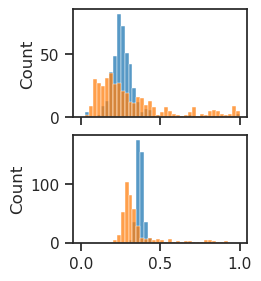

In [181]:
fig, axes = create_figure(2, 1, (2.5, 2.7), sharex='all', layout='constrained')

sns.histplot(fwd['r2'], bins=np.linspace(0, 1, 41), color='C0', ax=axes[0])
sns.histplot(bwd['r2'], bins=np.linspace(0, 1, 41), color='C1', ax=axes[0])
sns.histplot(fwd['a'], bins=np.linspace(0, 1, 41), color='C0', ax=axes[1])
sns.histplot(bwd['a'], bins=np.linspace(0, 1, 41), color='C1', ax=axes[1])
plt.show()

In [182]:
np.mean(fwd['a']), np.mean(bwd['a'])

(0.37909248, 0.35481358)

In [183]:
np.mean(fwd['r2']), np.mean(bwd['r2'])

(0.2671431381640323, 0.3317645109139954)

In [184]:
thres = 0.1
active_fwd = fwd['kl_tgt'] > thres
active_bwd = bwd['kl_tgt'] > thres
active_fwd.sum(), active_bwd.sum()

(13, 36)

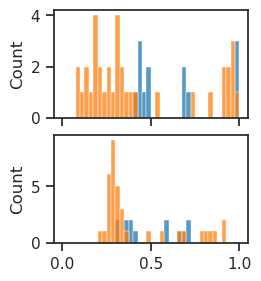

In [185]:
fig, axes = create_figure(2, 1, (2.5, 2.7), sharex='all', layout='constrained')

sns.histplot(fwd['r2'][active_fwd], bins=np.linspace(0, 1, 41), color='C0', ax=axes[0])
sns.histplot(bwd['r2'][active_bwd], bins=np.linspace(0, 1, 41), color='C1', ax=axes[0])
sns.histplot(fwd['a'][active_fwd], bins=np.linspace(0, 1, 41), color='C0', ax=axes[1])
sns.histplot(bwd['a'][active_bwd], bins=np.linspace(0, 1, 41), color='C1', ax=axes[1])
plt.show()

In [186]:
np.mean(fwd['a'][active_fwd]), np.mean(bwd['a'][active_bwd])

(0.50184447, 0.42023098)

In [187]:
np.mean(fwd['r2'][active_fwd]), np.mean(bwd['r2'][active_bwd])

(0.6332297860386131, 0.4352497100776799)

In [188]:
thres = 0.1
num = min(
    sum(fwd['kl_tgt'] > thres),
    sum(bwd['kl_tgt'] > thres),
)
num

13

In [189]:
num = 420

In [190]:
df = []
for d in [fwd, bwd]:
    ids = np.argsort(d['kl_tgt'])[::-1][:num]
    for k in ['a', 'r2']:
        cond = ' -> '.join([
            d['metadata']['model_src'],
            d['metadata']['model_tgt'],
        ])
        df.append({
            'cond': [cond] * num,
            'measure': [k] * num,
            'value': d[k][ids],
        })
df = pd.DataFrame(merge_dicts(df))

In [191]:
_PROPS = {
    'meanprops': {
        'marker': 'o',
        'markerfacecolor': 'white',
        'markeredgecolor': 'k',
        'markersize': 5,
        'alpha': 1.0},
    'flierprops': {
        'marker': 'o',
        'markersize': 2,
        'alpha': 0.3,
        'zorder': 1},
    'showfliers': True,
    'showmeans': True,
    'dodge': True,
    'width': 0.7,
}

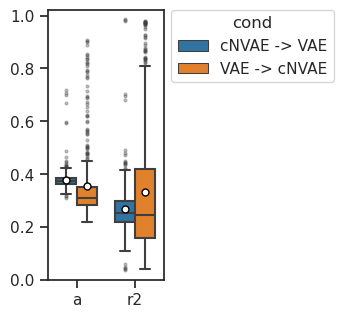

In [192]:
fig, ax = create_figure(1, 1, (1.5, 3.5))
sns.boxplot(
    data=df,
    x='measure',
    y='value',
    hue='cond',
    ax=ax,
    **_PROPS,
)
ax.set(
    xlabel='',
    ylabel='',
    ylim=(0, 1.02),
)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1, 1.03))

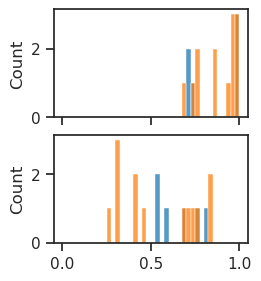

In [74]:
fig, axes = create_figure(2, 1, (2.5, 2.7), sharex='all', layout='constrained')

sns.histplot(fwd['r2'][active_fwd], bins=np.linspace(0, 1, 41), color='C0', ax=axes[0])
sns.histplot(bwd['r2'][active_bwd], bins=np.linspace(0, 1, 41), color='C1', ax=axes[0])
sns.histplot(fwd['a'][active_fwd], bins=np.linspace(0, 1, 41), color='C0', ax=axes[1])
sns.histplot(bwd['a'][active_bwd], bins=np.linspace(0, 1, 41), color='C1', ax=axes[1])
plt.show()

In [78]:
np.mean(fwd['a'][ids_fwd]), np.mean(bwd['a'][ids_bwd])

(0.65759635, 0.61317676)

In [79]:
np.mean(fwd['r2'][ids_fwd]), np.mean(bwd['r2'][ids_bwd])

(0.8517656359240225, 0.9155605905678663)

In [ ]:
fig, axes = create_figure(2, 1, (2.5, 2.7), sharex='all', layout='constrained')

sns.histplot(fwd['r2'][ids_fwd], bins=np.linspace(0, 1, 41), color='C0', ax=axes[0])
sns.histplot(bwd['r2'][ids_bwd], bins=np.linspace(0, 1, 41), color='C1', ax=axes[0])
sns.histplot(fwd['a'][ids_fwd], bins=np.linspace(0, 1, 41), color='C0', ax=axes[1])
sns.histplot(bwd['a'][ids_bwd], bins=np.linspace(0, 1, 41), color='C1', ax=axes[1])
plt.show()

In [59]:
np.mean(fwd['a'][active_fwd]), np.mean(bwd['a'][active_bwd])

(0.65759635, 0.61317676)

In [60]:
np.mean(fwd['r2'][active_fwd]), np.mean(bwd['r2'][active_bwd])

(0.8517656359240225, 0.9155605905678663)

In [2]:
tr = 'fixate1_nf-420_beta-0.2_(2023_04_30,21:37)'
tr = pjoin(results_dir(tr), 'Trainer')
tr = load_model_lite(tr, 'cuda:1')[0]

In [3]:
%%time

val, loss = tr.validate(use_ema=False)

CPU times: user 1min 52s, sys: 1min 10s, total: 3min 2s
Wall time: 4min 52s


In [7]:
print({
    k: v.mean() for k, v
    in loss.items()
})

{'epe': 2.4128628, 'kl': 33.918545, 'kl_diag': 0.08075845}

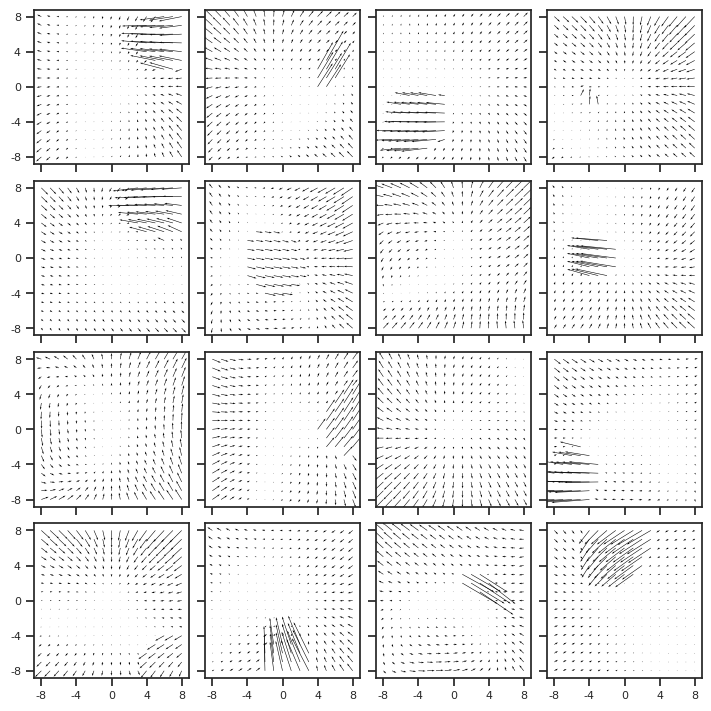

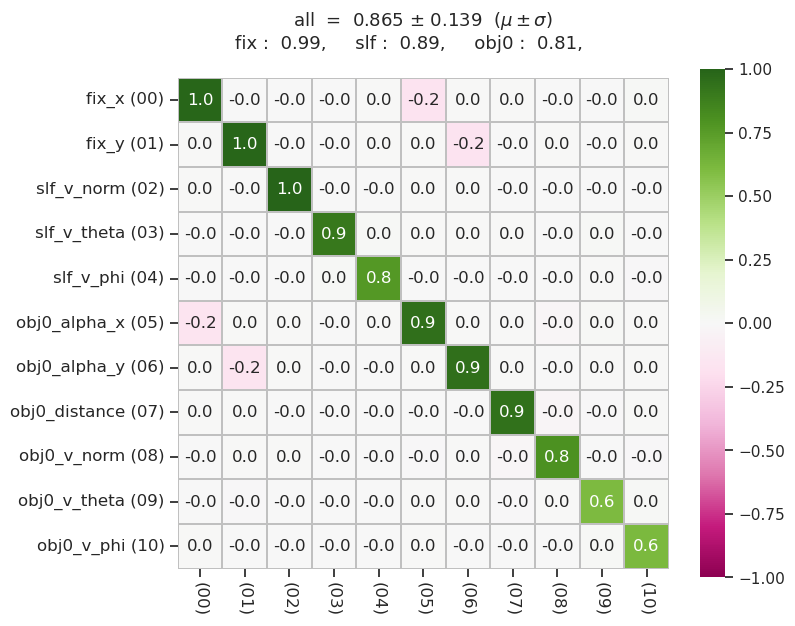

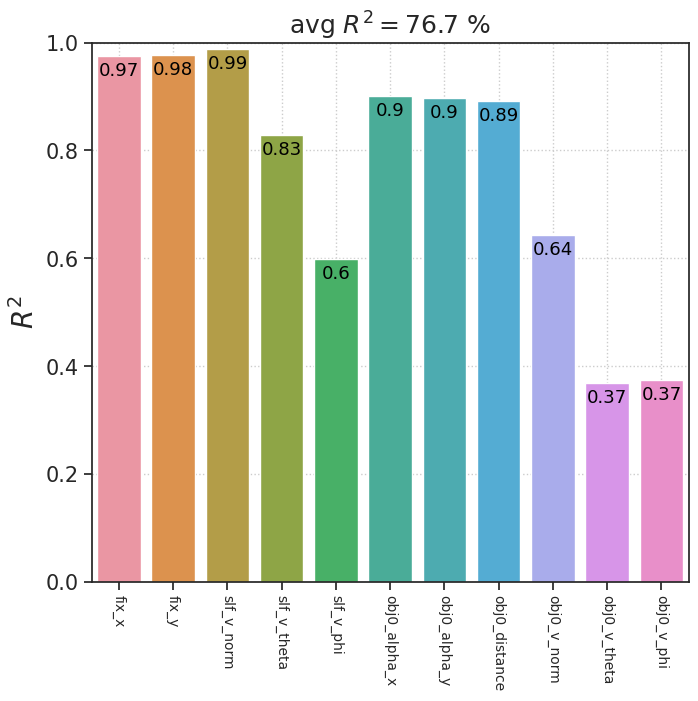

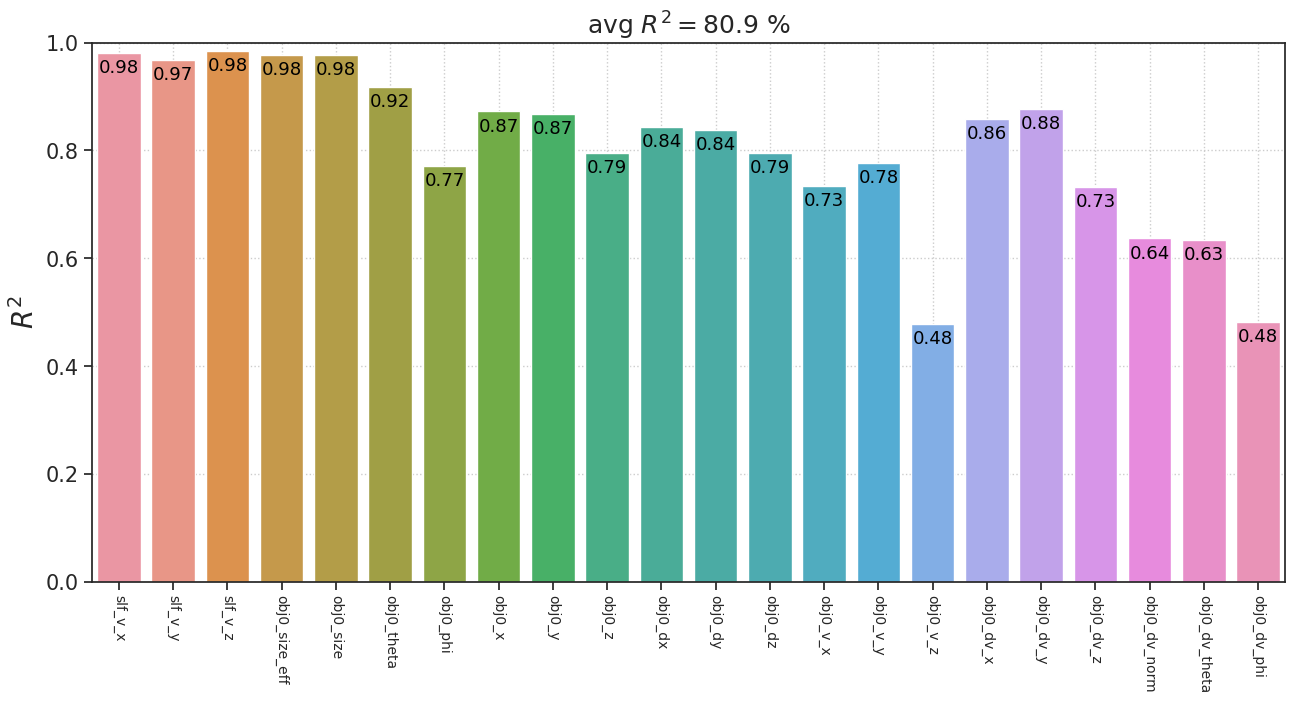

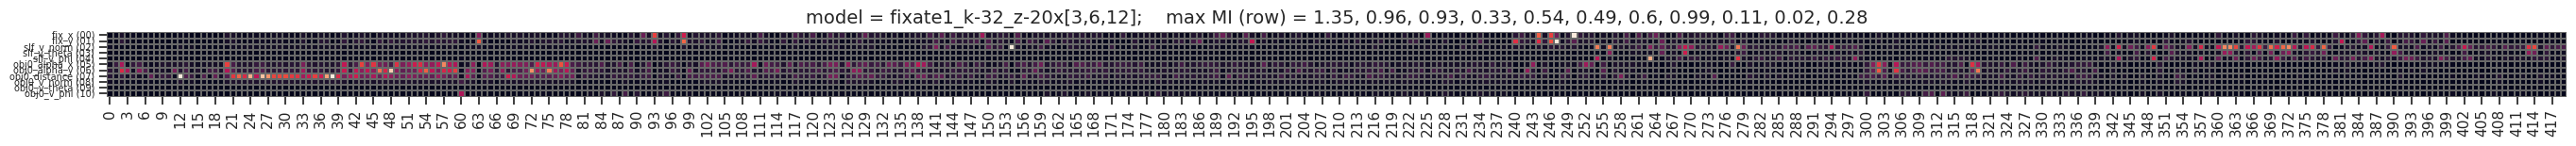

In [6]:
for k, v in val.items():
    if 'fig' in k:
        display(v)